In [203]:
!git add C1_Recurrent_neural_networks.ipynb
!git commit -m "RNN checkin"
!git push

The file will have its original line endings in your working directory


[master e2313e2] RNN checkin
 1 file changed, 195 insertions(+), 16 deletions(-)


To https://github.com/auslei/python.git
   eb28e56..e2313e2  master -> master


## Rcurent Neural Networks

A recurrent neural network looks very much like a feedforward neural network, except it also has connections pointing backward. At each step (or frame) at time t, the network receives input $x_{(t)}$ and also output from previous step $y_{(t-1)}$. At first step the output would be set to 0.

Every neuron has two sets of weights:
- $x_{(t)}$: we can call it $w_x$, which is a vector respect to inputs
- $y_{(t-1)}$: we can call it $w_y$, which is a vector respect to number of neurons

for each batch, then the $W_x$, and $W_y$ matrics stores the weights. 

The output of the neuron can then be expressed as:

$y_{(t)} = \phi(W_x^Tx_{(t)} + W_y^Ty_{(t-1)} + b)$

where $\phi$ is the activation function.

$Y_{(t)} = \phi(X_{(t)}W_x + Y_{(t-1)}W_y + b)$

Note: $Y_{(t)}$ is a function of all inputs from time t=0

In [1]:
## generate test data
import numpy as np
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 + np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) #wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

generate_time_series(1, 10) # returns numpy array of [batch_size, timestep, 1] - univariate dataset

array([[[ 1.4096347 ],
        [ 0.64607644],
        [-0.37780523],
        [ 0.49671283],
        [ 1.6168722 ],
        [-0.27689075],
        [-0.05848931],
        [ 1.2385324 ],
        [ 0.9313983 ],
        [-0.37114465]]], dtype=float32)

In [2]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]


In [3]:
series.shape, X_test.shape, y_test.shape

((10000, 51, 1), (1000, 50, 1), (1000, 1))

## Predict ahead

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

#simple model with one RNN neoron
model = keras.models.Sequential([
    SimpleRNN(1, input_shape = [None, 1])
])

#deep model with mulitple layers
model2 = Sequential([
    SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
    SimpleRNN(20, return_sequences = True),
    SimpleRNN(1) # last do not neeed the return sequencies
])


#deep model with dense at the end
model3 = Sequential([
    SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
    SimpleRNN(20),
    Dense(1)
])

model.summary() #3 parameters to train (Wx, Wy, b)

model2.summary() 

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1,282
Trainable params: 1,

In [5]:
history = []
keras.backend.clear_session()
es_cb = keras.callbacks.EarlyStopping(patience=5, min_delta = 1e3)

for m in [model, model2, model3]:
    m.compile(loss = 'mse', optimizer = 'adam')
    history.append(m.fit(X_train, y_train, callbacks = es_cb, validation_data=(X_valid, y_valid), epochs = 30, verbose = False))
    m.evaluate(X_test, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.0049


1/1 [==============================] - 0s 18ms/step


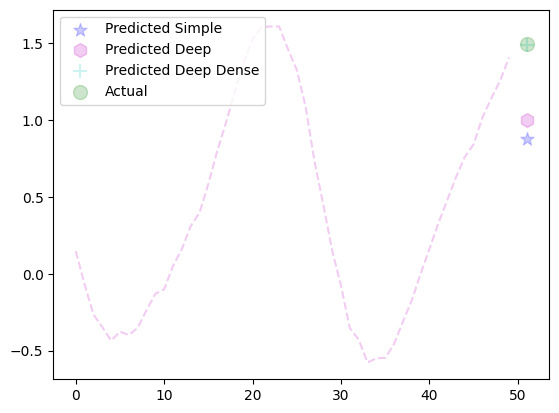

In [7]:
from matplotlib import pyplot as plt

seq = X_test[:1].squeeze()
y_pred = model.predict(X_test[:1]).squeeze()
y_pred2 = model2.predict(X_test[:1]).squeeze()
y_pred3 = model3.predict(X_test[:1]).squeeze()
y_act = y_test[:1].squeeze()


plt.plot(np.arange(50), seq, alpha = 0.2, color = 'm', linestyle = '--')
plt.scatter([51], [y_pred], s = 100, alpha = 0.2, color = 'b', marker = '*', label = "Predicted Simple")
plt.scatter([51], [y_pred2], s = 100, alpha = 0.2, color = 'm', marker = 'h', label = "Predicted Deep")
plt.scatter([51], [y_pred3], s = 100, alpha = 0.2, color = 'c', marker = '+', label = "Predicted Deep Dense")
plt.scatter([51], [y_act], s = 100, alpha = 0.2, color = 'g', marker = 'o', label = "Actual")

plt.legend()

plt.show()

## Forecast serveral time steps ahead

The trained model previous can also predict multiple steps ahead, by predicting ahead one by one. 

In [8]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]

X = X_new

# loop for each of the step from 0 - 9
for step_ahead in range(10):
    # predict by taking X, and sarting for starting with series fro step_ahead (note dim are [batch, series, 1])
    y_pred_one = model3.predict(X[:, step_ahead:])
    y_pred_one = y_pred_one[:, np.newaxis, :] # reshape to the same as X
    X = np.concatenate([X, y_pred_one], axis = 1) # add to X
    
y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 14ms/step


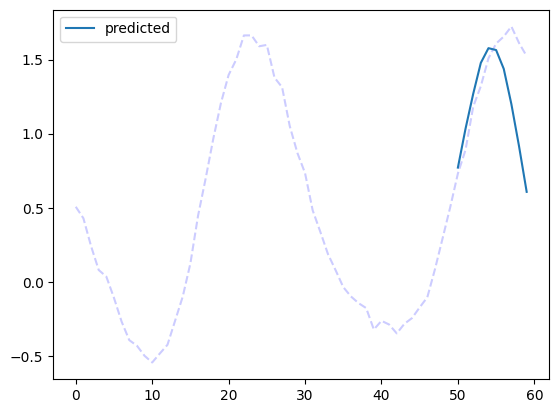

In [9]:
seq = X_new.squeeze()

plt.plot(np.arange(60), series.squeeze(), linestyle = '--', alpha = 0.2, color = 'b')
plt.plot(np.arange(60)[-10:], y_pred.squeeze(), label = 'predicted')
plt.legend()

plt.show()

## Train RNN to forcast serveral timesteps ahead

### Series to Vector: Passing a series and returns of a vector

In [10]:
keras.backend.clear_session()

series = generate_time_series(10000, n_steps + 10)
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

model4 = Sequential([
    SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
    SimpleRNN(20),
    Dense(10)
])


model4.compile(loss = 'mse', optimizer = 'adam')
history = model4.fit(X_train, y_train, callbacks = es_cb, validation_data=(X_valid, y_valid), 
                     epochs = 30, verbose = False)
model4.evaluate(X_test, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.0306


0.030613910406827927

In [11]:
y_pred = model4.predict(X_test[:1])
print(X_new.shape, y_pred.shape, y_pred.squeeze())

1/1 [==============================] - 0s 136ms/step
(1, 50, 1) (1, 10) [-0.06916574  0.20925722  0.594699    0.865825    1.1311553   1.248319
  1.5004756   1.4697095   1.4571224   1.3511885 ]


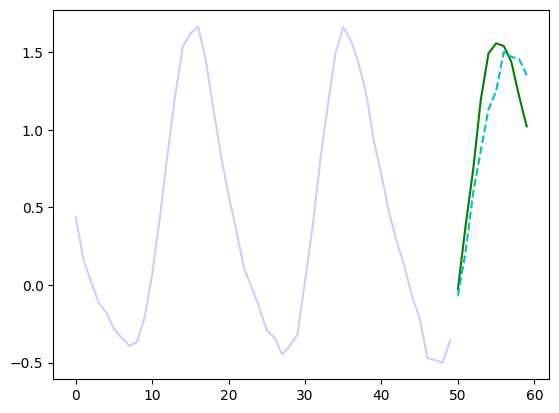

In [12]:
plt.plot(np.arange(50), X_test[:1].squeeze(), c = 'b', alpha = 0.2)
plt.plot(np.arange(60)[-10:], y_test[:1].squeeze(), c = 'g')
plt.plot(np.arange(60)[-10:], y_pred.squeeze(), c = 'c', linestyle = '--')

### Series to Series

Instead of returning a vector of the next # of steps, instead we can return the next # steps for each of the timestep. This is called series to series.

In [184]:
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):   # each target is a 10D vector (for each step, get the next 10 steps)
    Y[:, :, step_ahead - 1] = series[:, step_ahead : step_ahead + n_steps, 0]  # for each of the 10 targets in y, shift x across 10 steps and take the next 10 value
    
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [186]:
keras.backend.clear_session()

model5 = Sequential([
    SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
    SimpleRNN(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model5.summary()

# note as we are predicting next 10 values, only the last set of values are required to calc mse
def last_time_step_mse(Y_true, y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], y_pred[:, -1])

model5.compile(loss = last_time_step_mse, optimizer = 'adam')
history = model5.fit(X_train, Y_train, callbacks = es_cb, validation_data=(X_valid, Y_valid), 
                     epochs = 30, verbose = False)
model5.evaluate(X_test, Y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________
32/32 [==============================] - 0s 3ms/step - loss: 0.0217


0.021707693114876747

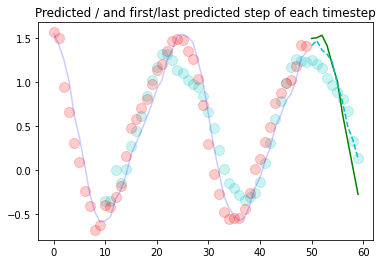

In [200]:
plt.title("Predicted / and first/last predicted step of each timestep")
plt.plot(np.arange(50), X_test[:1].squeeze(), c = 'b', alpha = 0.2)
plt.plot(np.arange(60)[-10:], Y_test[:1, -1:, :].squeeze(), c = 'g')
plt.plot(np.arange(60)[-10:], Y_pred[:1, -1:, :].squeeze(), c = 'c', linestyle = '--')
for i in range(50):
    yp = Y_pred[:1, i, :1].squeeze()
    yp2 = Y_pred[:1, i, -1:].squeeze()
    plt.scatter(i, yp, s = 100, c = 'r', alpha = 0.2)
    plt.scatter(i + 10, yp2, s = 100, c = 'c', alpha = 0.2)

In [183]:
Y_pred.shape # the predicted value therfore is batch_size * time_steps * target_vector_size

(1, 50, 10)

In [194]:
Y_test[:1, -1:, :]

array([[[ 1.49107289,  1.49910104,  1.5283035 ,  1.41031194,
          1.19457829,  1.00536525,  0.63221103,  0.3305915 ,
          0.02586286, -0.27563879]]])